In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns
import scipy.optimize as sco
import numpy.random as npr

In [2]:
xls = pd.ExcelFile("HW1_Due20180207.xlsx")
data = pd.read_excel(xls, "DataSource")
universe = pd.read_excel(xls, "DataSource_CAPMAssetClasses")

# Problem 1

In [3]:
VIX = data[['VIX Index', 'Unnamed: 1']]
VIX = VIX.rename(index=str, columns={'VIX Index':'Date', 'Unnamed: 1':'Price'})
VIX = VIX.iloc[1:]
VIX = VIX.set_index('Date')
VIX.dropna(inplace=True)
VIX.head()

,Price
Date,
1999-01-15,29.24
1999-01-19,29.24
1999-01-20,28.6
1999-01-21,30.92
1999-01-22,31.95


#1 transform VIX daily price time series to daily return time series

In [4]:
VIX['daily_ret'] = VIX['Price'].pct_change()
VIX.dropna(inplace=True)
VIX.head()

,Price,daily_ret
Date,,
1999-01-19,29.24,0.000000
1999-01-20,28.6,-0.021888
1999-01-21,30.92,0.081119
1999-01-22,31.95,0.033312
1999-01-25,31.13,-0.025665


#2 calculate the sample moments for the VIX daily returns

In [5]:
VIX_mean = VIX['daily_ret'].mean()
print('Mean of VIX daily returns: ' + str(VIX_mean))

Mean of VIX daily returns: 0.002357136485960589


In [6]:
VIX_skewness = VIX['daily_ret'].skew()
print('Skewness of VIX daily returns: ' + str(VIX_skewness))

Skewness of VIX daily returns: 2.0147831512243357


In [7]:
VIX_kurtosis = VIX['daily_ret'].kurtosis()
print('Kurtosis of VIX_kurtosis: ' + str(VIX_kurtosis))

Kurtosis of VIX_kurtosis: 19.302523257228803


#3 Test whether the VIX daily returns were normally distributed or not

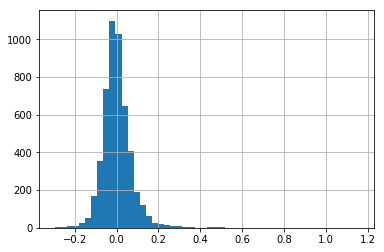

In [8]:
VIX['daily_ret'].hist(bins=50)
plt.show()

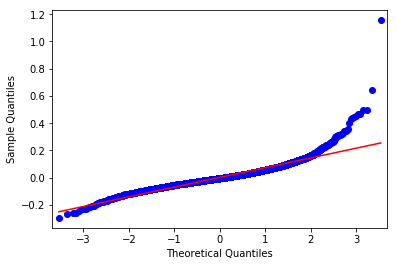

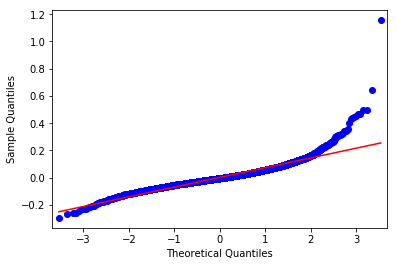

In [9]:
qqplot(VIX['daily_ret'], line='s')

Histrogram is not symetric and Normal Probability Plot shows that there are some outliers, the graph is more likely skew to the right

KS-test p-value = 0 with statistic = 0.433. Jarque-Bera test also has p-value =0 with a large statistic = 81178.60 which suggested that null hypothesis must be reject, VIX daily return is not normal distributed.

In [10]:
stats.kstest(VIX['daily_ret'], 'norm')

KstestResult(statistic=0.43284430209658664, pvalue=0.0)

In [11]:
stats.jarque_bera(VIX['daily_ret'])

(81178.59699074028, 0.0)

Conclusion: VIX daily return is not normally distributed

# Problem 2

In [12]:
SPY = data[['SPY ETF', 'Unnamed: 4']]
SPY.rename(index=str, columns={'SPY ETF':'Date', 'Unnamed: 4':'Price'}, inplace=True)
SPY = SPY.iloc[1:]
SPY.set_index('Date', inplace=True)
SPY.dropna(inplace=True)
SPY.head()

/Users/keyang/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Price
Date,
1999-01-15,124.375
1999-01-19,125.188
1999-01-20,126.188
1999-01-21,122.844
1999-01-22,122.562


#1 Calculate rolling 252-day annualied SPY return volatilities, and plot the time series

In [13]:
SPY['daily_ret'] = SPY['Price'].pct_change()
SPY['rolling_daily_vol']=SPY['daily_ret'].rolling(window=252).std()
SPY['annualied_vol'] = SPY['rolling_daily_vol'] * np.sqrt(252)
#SPY.head(253)

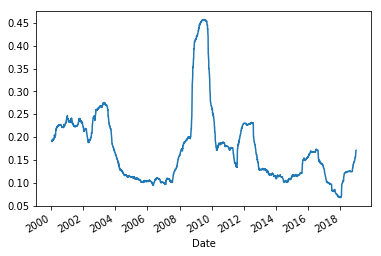

In [14]:
SPY['annualied_vol'].plot()
plt.show()

#2. Calculate rolling 252-day annualized SPY return semi-volatility (based on negative daily returns) , and plot the time series

In [15]:
SPY['neg_daily_ret'] = np.minimum(SPY['daily_ret'], 0)  #If return is not negative we set it as 0
SPY['neg_daily_ret'].dropna(inplace=True)
SPY['rolling_semi_vol']=SPY['neg_daily_ret'].rolling(window=252).std()
SPY['semi_annualied_vol'] = SPY['rolling_semi_vol'] * np.sqrt(252)
SPY.tail()

/Users/keyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in minimum
  """Entry point for launching an IPython kernel.


,Price,daily_ret,rolling_daily_vol,annualied_vol,neg_daily_ret,rolling_semi_vol,semi_annualied_vol
Date,,,,,,,
2018-12-24,234.34,-0.026423,0.010257,0.162820,-0.026423,0.007260,0.115254
2018-12-26,246.18,0.050525,0.010748,0.170620,0.000000,0.007261,0.115262
2018-12-27,248.07,0.007677,0.010760,0.170803,0.000000,0.007263,0.115296
2018-12-28,247.75,-0.001290,0.010760,0.170804,-0.001290,0.007261,0.115260
2018-12-31,249.92,0.008759,0.010774,0.171026,0.000000,0.007261,0.115260


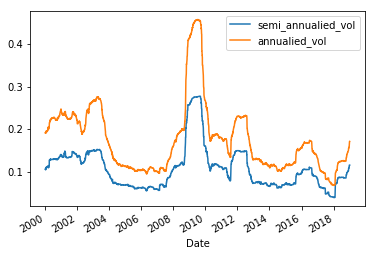

In [16]:
SPY['semi_annualied_vol'].plot()
SPY['annualied_vol'].plot()
plt.legend()
plt.show()


#3A  calculate its shortfall probability for a daily return less than -2% 

In [17]:
SPY2018 = SPY.loc["2018-01-02":]  #SPY daily returns in 2018

In [18]:
shortFall = SPY2018.loc[SPY2018['daily_ret']<-0.02]    #daily return less than 0.02
prob_shortFall = shortFall.count()['daily_ret'] / SPY2018.count()['daily_ret']
print("Shortfall Probablity: "+str(prob_shortFall))

Shortfall Probablity: 0.055776892430278883


#3B Value at Risk at 95% for daily return

In [19]:
sorted_rets = sorted(SPY2018['daily_ret'])
VaR = np.percentile(sorted_rets, 5)
print("Value at Risk at 95%: " + str(VaR))

Value at Risk at 95%: -0.02144958473986508


#3C CVaR-95% for daily return.

In [20]:
CVaR = SPY2018.loc[SPY2018['daily_ret']<VaR]['daily_ret'].mean()
print("Conditional Value at Risk at 95%: " + str(CVaR))

Conditional Value at Risk at 95%: -0.02786116034896852


#4 Calculate drawdowns for the SPY price times series, plot the drawdown time series, and locate the maximum drawdown for the whole period

In [21]:
SPY['value'] = (1+SPY['daily_ret']).cumprod()
SPY['cummax'] = SPY['value'].cummax()
SPY['drawDown'] = (SPY['value']/SPY['cummax']-1)
SPY['drawDown']


Date
1999-01-15         NaN
1999-01-19    0.000000
1999-01-20    0.000000
1999-01-21   -0.026498
1999-01-22   -0.028727
1999-01-25   -0.018821
1999-01-26   -0.000991
1999-01-27   -0.012630
1999-01-28    0.000000
1999-01-29    0.000000
1999-02-01   -0.005875
1999-02-02   -0.011995
1999-02-03   -0.001958
1999-02-04   -0.016891
1999-02-05   -0.028152
1999-02-08   -0.026194
1999-02-09   -0.047980
1999-02-10   -0.041861
1999-02-11   -0.019829
1999-02-12   -0.031579
1999-02-16   -0.037454
1999-02-17   -0.038434
1999-02-18   -0.030845
1999-02-19   -0.026683
1999-02-22   -0.000735
1999-02-23   -0.001224
1999-02-24   -0.018850
1999-02-25   -0.028152
1999-02-26   -0.032069
1999-03-01   -0.029376
                ...   
2018-11-15   -0.070032
2018-11-16   -0.067614
2018-11-19   -0.083384
2018-11-20   -0.100347
2018-11-21   -0.097282
2018-11-23   -0.103311
2018-11-26   -0.088834
2018-11-27   -0.085769
2018-11-28   -0.064718
2018-11-29   -0.066762
2018-11-30   -0.061074
2018-12-03   -0.048641
2018-1

In [22]:
SPY_maxDD = SPY['drawDown'].min()
print(SPY_maxDD)

-0.5647367075664627


In [23]:
SPY.loc[SPY['drawDown'] == SPY_maxDD]['drawDown']

Date
2009-03-09   -0.564737
Name: drawDown, dtype: float64

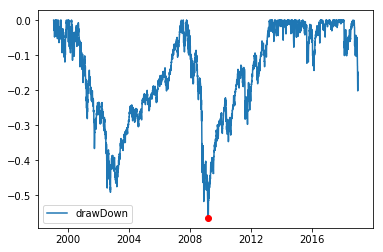

In [24]:
plt.plot(SPY['drawDown'])
plt.plot(SPY.loc[SPY['drawDown'] == SPY_maxDD]['drawDown'].index, SPY_maxDD, 'ro')
plt.legend()
plt.show()

# Problem 3


In [25]:
universe = universe[1:]
#universe.dtypes

In [26]:
universe = universe.astype(float)
#universe.dtypes

 the historical Return

In [27]:
universe_ret_mean = universe.mean()
expect_ret = universe_ret_mean #*12
expect_ret

Fixed-Income: Treasury Inflation Protected Securities (TIPS)         0.437099
Fixed-Income: U.S. Treasury Bonds and Investment Grade Corp Bonds    0.376141
Fixed-Income: U.S. High Yield Corp Bonds                             0.544297
Fixed-Income: Non U.S. Sovereign Bonds                               0.306478
Equities: U.S. Large Cap Growth                                      0.529154
Equities: U.S. Large Cap Value                                       0.587983
Equities: U.S. Small Cap Growth                                      0.706208
Equities: U.S. Small Cap Value                                       0.795998
Equities: Developed Countries Non-US                                 0.401529
Equities: Emerging Markets                                           0.884078
Commodities                                                          0.262214
Real Estate                                                          0.957580
dtype: float64

Estimate Covariance Martix

In [28]:
universe_cov_matrix = universe.cov()
#sigma = universe_cov_matrix *12
#sigma

In [29]:
def portfolio_calculation(weight, cov_matrix): 
    '''
    This is function in order to calculate the portfolio return, volatility and Sharpe Ratio
    '''
    w = np.array(weight)

    prof_return = np.sum(expect_ret * w* 12)  #annualized return
    prof_volatility = np.sqrt(np.dot(w.T, np.dot(universe_cov_matrix * 12, w)))  
    sharpe_ratio = (prof_return - risk_free_rate) / prof_volatility     
    return np.array([prof_return, prof_volatility, sharpe_ratio])

# minimize negative return = maxmize positive return
def returns(weight):
    return -portfolio_calculation(weight)[0]

def volatility(weight):
    return portfolio_calculation(weight)[1]

# minimize negative Sharpe ratio = maximize positive Sharpe ratio
def sharpe_ratio(weight):
    return -portfolio_calculation(weight)[2]


In [30]:
def results():
    '''
    return the weights of portfolio of minimum volatility, maximum return and maximum sharpe ratio
    '''
    num_universe = len(expect_ret.index) #number of asset classes
    arg = ()
    consts = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) #weights sum up to one
    bnds = tuple((0.0, 1.0) for i in range(num_universe)) #not short-sell allowed so bond from 0 to 1
    
    min_volatility = sco.minimize(volatility, num_universe*[1./num_universe,],args= arg ,
                        method='SLSQP', bounds=bnds, constraints=consts)
    max_ret = sco.minimize(returns, num_universe*[1./num_universe,],args= arg ,
                        method='SLSQP', bounds=bnds, constraints=consts)
    max_sr = sco.minimize(sharpe_ratio, num_universe*[1./num_universe,],args= arg ,
                        method='SLSQP', bounds=bnds, constraints=consts)

    return min_volatility['x'].round(4), max_ret['x'].round(4), max_sr['x'].round(4)

In [31]:
risk_free_rate = 0 #assume risk free rate is 0
results()

(array([0.    , 0.9265, 0.    , 0.    , 0.013 , 0.0388, 0.0081, 0.    ,
        0.    , 0.    , 0.0136, 0.    ]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.    , 0.8967, 0.0241, 0.    , 0.0058, 0.0144, 0.    , 0.0591,
        0.    , 0.    , 0.    , 0.    ]))

In [32]:
def display_result():
    '''
    Display all weights clearly
    '''

    weights_min_vol, weights_max_ret, weights_max_sr = results()

    min_vol = volatility(weights_min_vol)
    prof_return1 = -returns(weights_min_vol)
    SR = -sharpe_ratio(weights_min_vol)    
    
    minVolatility_allocation = pd.DataFrame(weights_min_vol, index=universe_cov_matrix.columns, columns=['Weights'])
    print("Minimum Volatility Portfolio Allocation\n")
    print("Minimum Volatility: {}%".format(round(min_vol,2)))
    print("Portfoilo Return: {}%".format(round(prof_return1, 2)))
    print("Portfoilo Sharpe Ratio: ", round(SR, 2))
    print("-"*60)
    print(minVolatility_allocation)
    
    print('\n')
    print("-"*60)
    VOL = volatility(weights_max_ret)
    max_return = -returns(weights_max_ret)
    sr = -sharpe_ratio(weights_max_ret)    
    maxReturn_allocation = pd.DataFrame(weights_max_ret, index=universe_cov_matrix.columns, columns=['Weights'])
    print("Maximum Return Portfolio Allocation\n")
    print("Volatility: {}%".format(round(VOL,2)))
    print("Portfoilo Return: {}%".format(round(max_return, 2)))
    print("Maximum Sharpe Ratio: ", round(sr, 2))
    print("-"*60)
    print(maxReturn_allocation)     
    
    
    print('\n')
    print("-"*60)
    vol = volatility(weights_max_sr)
    prof_return2 = -returns(weights_max_sr)
    max_SR = -sharpe_ratio(weights_max_sr)    
    maxSharpeRatio_allocation = pd.DataFrame(weights_max_sr, index=universe_cov_matrix.columns, columns=['Weights'])
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Volatility: {}%".format(round(vol,2)))
    print("Portfoilo Return: {}%".format(round(prof_return2, 2)))
    print("Maximum Sharpe Ratio: ", round(max_SR, 2))
    print("-"*60)
    print(maxSharpeRatio_allocation)    
    
    

#1, 2A  Minimum-variance portfolio and two other efficient frontier (max sharpe ratio portfolio and max return portfolio)

In [33]:
display_result()

Minimum Volatility Portfolio Allocation

Minimum Volatility: 3.2%
Portfoilo Return: 4.65%
Portfoilo Sharpe Ratio:  1.45
------------------------------------------------------------
                                                    Weights
Fixed-Income: Treasury Inflation Protected Secu...   0.0000
Fixed-Income: U.S. Treasury Bonds and Investmen...   0.9265
Fixed-Income: U.S. High Yield Corp Bonds             0.0000
Fixed-Income: Non U.S. Sovereign Bonds               0.0000
Equities: U.S. Large Cap Growth                      0.0130
Equities: U.S. Large Cap Value                       0.0388
Equities: U.S. Small Cap Growth                      0.0081
Equities: U.S. Small Cap Value                       0.0000
Equities: Developed Countries Non-US                 0.0000
Equities: Emerging Markets                           0.0000
Commodities                                          0.0136
Real Estate                                          0.0000


-------------------------------------

#2B According to the result above, we can see that the minimum-variance portfolio is not a combination of max-return portfolio and max-sharpe-ratio portfolio. In max return portfolio, putting all the money in real estate class, but weight is 0 in minimum-variance portfolio and max-return portfolio. So it disproves two fund therom.

#3. Plot both the old efficient frontier without the short-sell constraint and the new efficient frontier with the short-sell constraint on the same graph.

In [34]:
def results_with_short():
    '''
    calculate maximum return, minimum volatility and maximum Sharpe ratio
    '''
    num_universe = len(expect_ret.index)
    arg = ()
    consts = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bnds = ()
    min_volatility = sco.minimize(volatility, num_universe*[1./num_universe,],args= arg ,
                        method='SLSQP', bounds=bnds, constraints=consts)
    max_ret = sco.minimize(returns, num_universe*[1./num_universe,],args= arg ,
                        method='SLSQP', bounds=bnds, constraints=consts)
    max_sr = sco.minimize(sharpe_ratio, num_universe*[1./num_universe,],args= arg ,
                        method='SLSQP', bounds=bnds, constraints=consts)

    return min_volatility['x'].round(4), max_ret['x'].round(4), max_sr['x'].round(4)

In [35]:
def efficient_frontier_without_short(target):
    '''
    return the weights of portfolio of minimum volatility, maximum return and maximum sharpe ratio
    '''
    num_universe = len(expect_ret.index) #number of asset classes
    arg = ()
    consts = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
             {'type': 'eq', 'fun': lambda x: -returns(x) - target}) #expected return higher than target return
    bnds = tuple((0.0, 1.0) for i in range(num_universe)) #not short-sell allowed so bond from 0 to 1
    
    min_volatility = sco.minimize(volatility, num_universe*[1./num_universe,],args= arg ,
                        method='SLSQP', bounds=bnds, constraints=consts)
    max_ret = sco.minimize(returns, num_universe*[1./num_universe,],args= arg ,
                        method='SLSQP', bounds=bnds, constraints=consts)
    max_sr = sco.minimize(sharpe_ratio, num_universe*[1./num_universe,],args= arg ,
                        method='SLSQP', bounds=bnds, constraints=consts)

    return min_volatility['x'].round(4), max_ret['x'].round(4), max_sr['x'].round(4)

In [36]:
#def two_fund_thm_without_short(portion):
#    weights_min_vol, weight_max_ret, weights_max_sr = results()
#    return (1-portion)*weights_min_vol+portion*weights_max_sr

def two_fund_thm_with_short(portion):
    weights_min_vol, weight_max_ret, weights_max_sr = results_with_short()
    return (1-portion)*weights_min_vol+portion*weights_max_sr

In [37]:
c = np.array(np.linspace(0,1,100))
targe_ret = np.linspace(4.65,5.25,100)
port_ret_without_short = []
port_vol_without_short = []
port_ret_with_short = []
port_vol_with_short = []


for x in targe_ret:  
    w1, w2, w3 = efficient_frontier_without_short(x)
    portfolio_return1 = -returns(w1)
    portfolio_vol1 = volatility(w1)
    
    port_ret_without_short.append(portfolio_return1)
    port_vol_without_short.append(portfolio_vol1)
    
for i in c:    
    portfolio_return2 = -returns(two_fund_thm_with_short(i))
    portfolio_vol2 = volatility(two_fund_thm_with_short(i))

    port_ret_with_short.append(portfolio_return2)
    port_vol_with_short.append(portfolio_vol2)
    


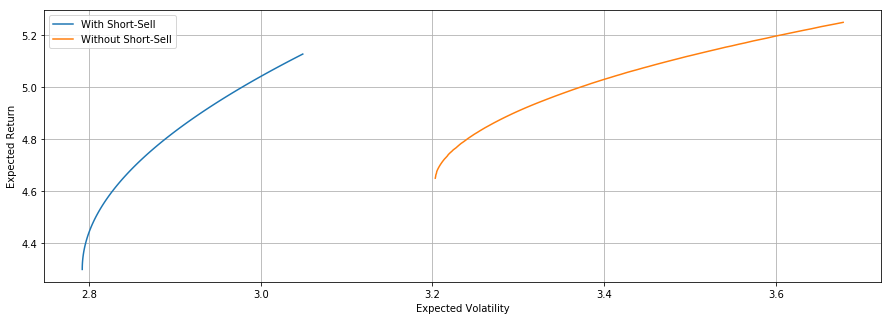

In [38]:
plt.figure(figsize=(15,5))
plt.plot(port_vol_with_short, port_ret_with_short, label='With Short-Sell')
plt.plot(port_vol_without_short, port_ret_without_short, label='Without Short-Sell')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.legend()
plt.grid()
plt.show()